In [2]:
from datetime import datetime
from typing import List, Tuple

import cloudpickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
device = tf.device(device_name)


In [3]:
df = pd.read_csv('data/BTCRUB.csv')
df 

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,num_trades,base_asset_volume,buy_quote_asset_volume,unused_field
0,1575291600000,464070.0,469552.0,464070.0,469552.0,0.032662,1575295199999,1.533096e+04,7,0.010952,5.137052e+03,0
1,1575295200000,467331.0,471594.0,467331.0,467630.0,0.134229,1575298799999,6.309456e+04,14,0.024088,1.134293e+04,0
2,1575298800000,467630.0,469670.0,467630.0,469007.0,0.082306,1575302399999,3.860811e+04,6,0.001694,7.921652e+02,0
3,1575302400000,469618.0,469630.0,468789.0,469630.0,0.106682,1575305999999,5.005931e+04,5,0.106469,4.995928e+04,0
4,1575306000000,467515.0,467692.0,465809.0,466491.0,0.185732,1575309599999,8.684838e+04,11,0.179838,8.409892e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29340,1681030800000,2284327.0,2289601.0,2283575.0,2286171.0,0.723910,1681034399999,1.655899e+06,138,0.499980,1.143775e+06,0
29341,1681034400000,2287094.0,2287397.0,2283820.0,2284298.0,0.287650,1681037999999,6.575263e+05,89,0.173290,3.961601e+05,0
29342,1681038000000,2284988.0,2289976.0,2283246.0,2289147.0,0.415640,1681041599999,9.504584e+05,94,0.149920,3.430086e+05,0
29343,1681041600000,2289862.0,2293561.0,2287523.0,2287886.0,0.228180,1681045199999,5.223882e+05,110,0.090030,2.061962e+05,0


# 1. Data Understanding

In [4]:
df.isnull().sum()

open_time                 0
open_price                0
high_price                0
low_price                 0
close_price               0
volume                    0
close_time                0
quote_asset_volume        0
num_trades                0
base_asset_volume         0
buy_quote_asset_volume    0
unused_field              0
dtype: int64

In [5]:
sum(df.duplicated())

0

In [6]:
# Конверттруем timestamp to datetime(делим на 1000 потому что binance возвращает миллисекунды)
df = df.sort_values(by='open_time')
df['open_time'] = df.open_time.apply(lambda x: datetime.fromtimestamp(x / 1000))

# Смотрим на диапазон
df.open_time.agg({'min', 'max'})

max   2023-04-09 13:00:00
min   2019-12-02 13:00:00
Name: open_time, dtype: datetime64[ns]

In [7]:
# Есть пропуски во времени. Возможно при формировании обучайщей выборки это надо учесть
print(f'Количество загруженных строк: {df.shape[0]}')
print(f'Должно быть строк: {(df.open_time.max() - df.open_time.min()).total_seconds() // 3600}')

Количество загруженных строк: 29345
Должно быть строк: 29376.0


In [8]:
# Смотрим насколько критичны пропуски
missed = []
no_missed = []
for i in range(0, df.shape[0] - 1):
    difference = (df.open_price[i + 1] - df.open_price[i]) / df.open_price[i]
    if (df.open_time[i + 1] - df.open_time[i]).total_seconds() != 3600:
        missed.append(difference)
    else:
        no_missed.append(difference)
        
print(f'Количество пропусков: {len(missed)}') 
print(f'Средняя разница missed: {np.mean(np.abs(missed))}')
print(f'Средняя разница no_missed: {np.mean(np.abs(no_missed))}')
# Попробуем оставить так, как есть. Надеюсь это сильно не повлияет на качество

Количество пропусков: 15
Средняя разница missed: 0.003521547521009891
Средняя разница no_missed: 0.004997855652560604


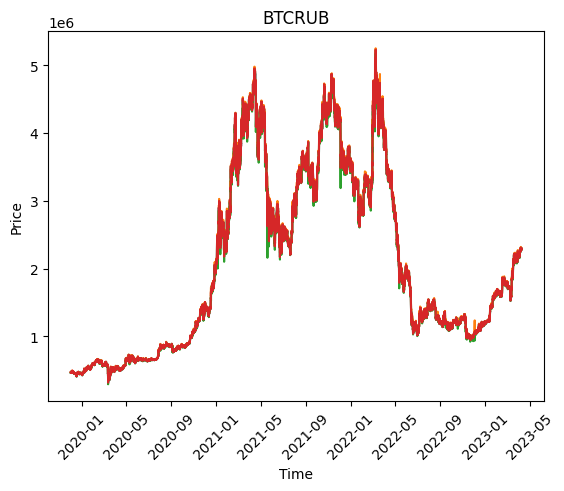

In [9]:
for col in ['open_price', 'high_price', 'low_price', 'close_price']:
    plt.plot(df['open_time'], df[col])

plt.title('BTCRUB')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [10]:
df.drop(['unused_field', 'close_time'], axis=1, inplace=True)

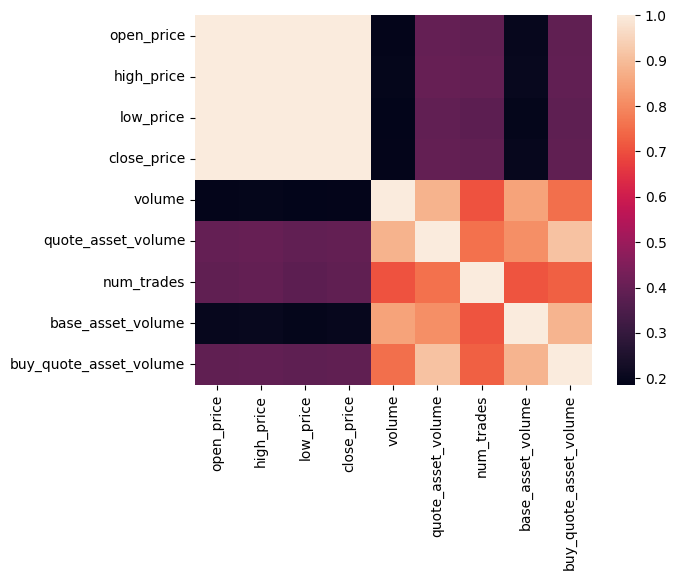

In [11]:
sns.heatmap(df.corr());

# 2. Data Preparation

In [12]:
features = ['open_price', 'high_price', 'low_price', 'close_price']

In [13]:
# Делим данные на трейн и тест
train_size = int(df.shape[0] * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

train.shape, test.shape

((23476, 10), (5869, 10))

In [14]:
# Маштабируем данные
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train[features]), columns=features)
test = pd.DataFrame(scaler.transform(test[features]), columns=features)

In [15]:
# Создаем обучающие данные
def create_data(df: pd.DataFrame, window_size: int,
                feature_names: List[str]) -> Tuple[np.ndarray]:
    
    length = df.shape[0] - window_size
    features = df[feature_names].values
    
    X = np.array([features[i: i + window_size] for i in range(length)])
    y = np.array([features[i + window_size] for i in range(length)])
    
    return X, y 

# Количество часов по которым будем делать прогноз
num_hours = 72
X_train, y_train = create_data(train, num_hours, features)
X_test, y_test = create_data(test, num_hours, features)

# 3. Modeling

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=len(features), activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50)

# 4. Results

In [24]:
def mae(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    y_pred = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_true)
    difference = np.abs(y_true - y_pred)
    means = difference.mean(axis=0) 
    return np.round(means)


y_pred_train = model.predict(X_train, verbose=False)
y_pred_test = model.predict(X_test, verbose=False)

mae_train = mae(y_pred_train, y_train)
mae_test = mae(y_pred_test, y_test)

print(f'Std of prices: {np.round(scaler.inverse_transform(y_train).std(axis=0))}')
print(f'MAE Train: {mae_train}')
print(f'MAE Test: {mae_test}')

Std of prices: [1412701. 1420867. 1403717. 1412630.]
MAE Train: [20631. 21981. 25080. 24119.]
MAE Test: [13684. 14866. 12360. 14933.]


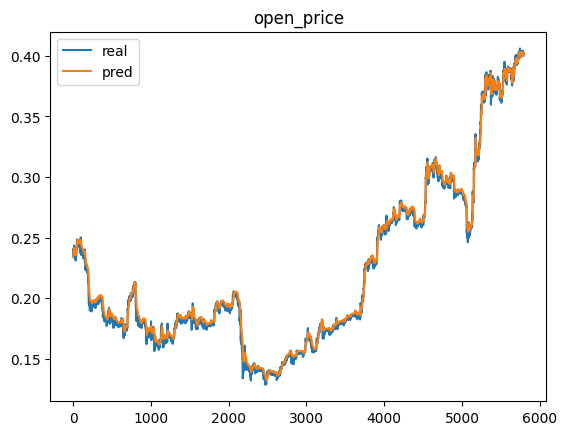

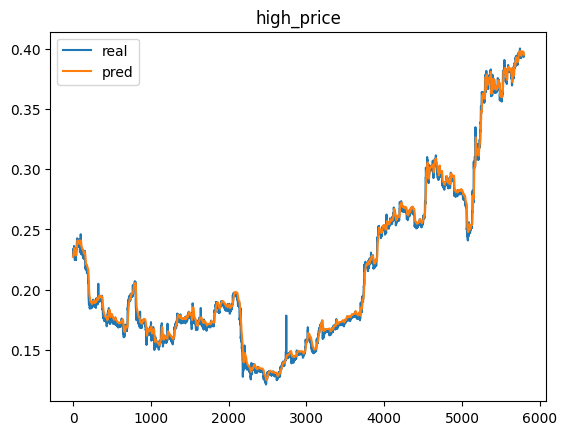

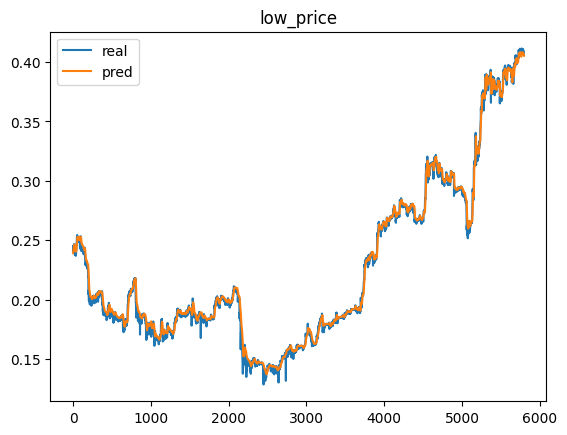

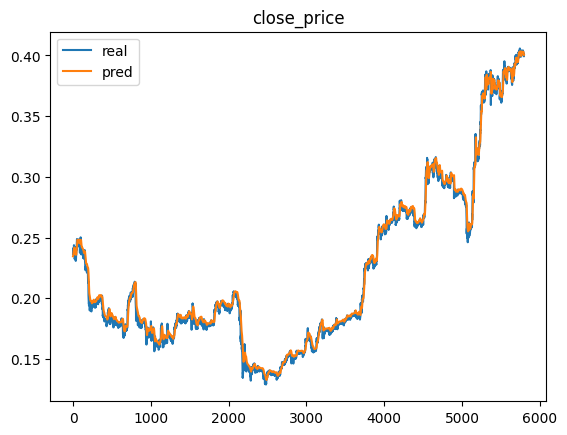

In [25]:
# Cмотрим на графики
for i in range(len(features)): 
    plt.plot(y_test[:, i], label='real')
    plt.plot(y_pred_test[:, i], label='pred')
    plt.legend()
    plt.title(features[i])
    plt.show()

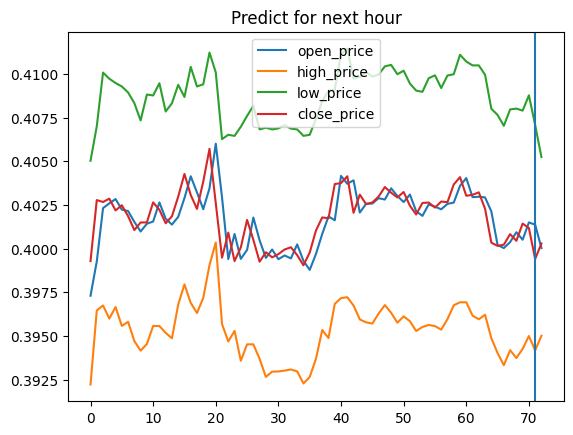

In [26]:
# Предсказываем на следующий час 
next_hour = model.predict(X_test[-1:], verbose=False)
plt.plot(np.concatenate((y_test[-num_hours:], next_hour), axis=0), label=features)
plt.title('Predict for next hour')
plt.legend()
plt.axvline(x=num_hours - 1)
plt.show()

# 5. Save model

In [27]:
def predict(X: np.ndarray) -> np.ndarray:
    assert X.shape[0] == num_hours, f'X must have {num_hours} elements'
    X = scaler.transform(X)
    pred = model.predict(X[np.newaxis], verbose=False)
    pred = scaler.inverse_transform(pred)[0]    
    return pred


# Сохраняем функцию со всеми зависимостями для дальнейшего использования
with open('data/predict.bin', 'wb') as file:
    cloudpickle.dump(predict, file) 